In [1]:
%load_ext autoreload
%autoreload 2

import anndata as ad
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
from mmd_wrapper.utilities import alignment_visualize, pairwise_error
import numpy as np
import pandas as pd

from nmacom import NMAcom

2021-10-12 20:13:47.591538: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-12 20:13:47.591574: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


# Read Data

In [2]:
# X1 = ad.read_h5ad('OPSCA/openproblems_bmmc_multiome_starter/openproblems_bmmc_multiome_starter.mod1.h5ad')
# X2 = ad.read_h5ad('OPSCA/openproblems_bmmc_multiome_starter/openproblems_bmmc_multiome_starter.mod2.h5ad')
X1 = ad.read_h5ad('OPSCA/openproblems_bmmc_multiome_phase1/openproblems_bmmc_multiome_phase1.censor_dataset.output_mod1.h5ad')
X2 = ad.read_h5ad('OPSCA/openproblems_bmmc_multiome_phase1/openproblems_bmmc_multiome_phase1.censor_dataset.output_mod2.h5ad')
X1 = X1.X[:500]
X2 = X2.X[:500]

# Run Mapping

In [3]:
nmacom_out = NMAcom().fit_transform([X1, X2])

use random seed: 666
Shape of Raw data
Dataset 0: (500, 13431)
Dataset 1: (500, 116490)
---------------------------------
Find correspondence between Dataset 1 and Dataset 1
use device: cpu
epoch:[100/2000] err:8.0733 alpha:3.2889
epoch:[200/2000] err:1.0465 alpha:0.4462
epoch:[300/2000] err:1.2730 alpha:0.5764
epoch:[400/2000] err:1.2063 alpha:0.6188
epoch:[500/2000] err:1.1114 alpha:0.6548
epoch:[600/2000] err:1.0139 alpha:0.6868
epoch:[700/2000] err:0.9361 alpha:0.7156
epoch:[800/2000] err:0.8830 alpha:0.7413
epoch:[900/2000] err:0.8489 alpha:0.7643
epoch:[1000/2000] err:0.8264 alpha:0.7850
epoch:[1100/2000] err:0.8095 alpha:0.8037
epoch:[1200/2000] err:0.7949 alpha:0.8207
epoch:[1300/2000] err:0.7820 alpha:0.8362
epoch:[1400/2000] err:0.7703 alpha:0.8503
epoch:[1500/2000] err:0.7597 alpha:0.8631
epoch:[1600/2000] err:0.7503 alpha:0.8748
epoch:[1700/2000] err:0.7419 alpha:0.8855
epoch:[1800/2000] err:0.7343 alpha:0.8952
epoch:[1900/2000] err:0.7272 alpha:0.9040
epoch:[2000/2000] err

# Compare

In [4]:
# NMAcom
print('NMAcom Pairwise Error: ' + str(pairwise_error(*nmacom_out, normalize_by_feature=True)))
print()

# Create dense data
densify = lambda df: np.array(df.todense())
X1_dense = densify(X1)
X2_dense = densify(X2)

# UnionCom
unioncom_out = mmd_combine(X1_dense, X2_dense, method='unioncom', verbose=0)
print('UnionCom Pairwise Error: ' + str(pairwise_error(*unioncom_out[0], normalize_by_feature=True)))
print()

# ManiNetCluster
maninetcluster_out = mmd_combine(X1_dense, X2_dense,
                                 method='maninetcluster',
                                 alignment='nonlinear manifold aln',
                                 num_dims=2)
print('ManiNetCluster Pairwise Error: ' + str(pairwise_error(*maninetcluster_out[0], normalize_by_feature=True)))

NMAcom Pairwise Error: 1.2666489044495393

UnionCom Pairwise Error: 26.014182452112436

ManiNetCluster Pairwise Error: 16.94861821868187


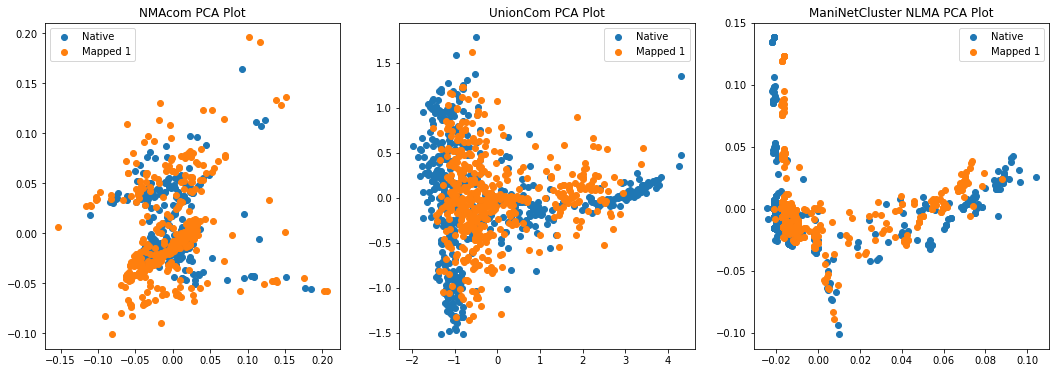

In [5]:
mappings = [nmacom_out, unioncom_out[0], maninetcluster_out[0]]
names = ['NMAcom', 'UnionCom', 'ManiNetCluster NLMA']

plt.subplots(figsize=(6*len(names), 6))
for i, mapping in enumerate(mappings):
    plt.subplot(1, len(names), i+1)
    alignment_visualize(*mapping, alg_name=names[i])